In [1]:
%cd ..

/Users/uribagi/Documents/GitHub/Latent-IQP


Epoch 1/20 - Train Loss: 0.0631
Epoch 2/20 - Train Loss: 0.0416
Epoch 3/20 - Train Loss: 0.0378
Epoch 4/20 - Train Loss: 0.0359
Epoch 5/20 - Train Loss: 0.0349
Epoch 6/20 - Train Loss: 0.0342
Epoch 7/20 - Train Loss: 0.0337
Epoch 8/20 - Train Loss: 0.0333
Epoch 9/20 - Train Loss: 0.0330
Epoch 10/20 - Train Loss: 0.0327
Epoch 11/20 - Train Loss: 0.0325
Epoch 12/20 - Train Loss: 0.0324
Epoch 13/20 - Train Loss: 0.0321
Epoch 14/20 - Train Loss: 0.0320
Epoch 15/20 - Train Loss: 0.0318
Epoch 16/20 - Train Loss: 0.0317
Epoch 17/20 - Train Loss: 0.0316
Epoch 18/20 - Train Loss: 0.0314
Epoch 19/20 - Train Loss: 0.0313
Epoch 20/20 - Train Loss: 0.0312


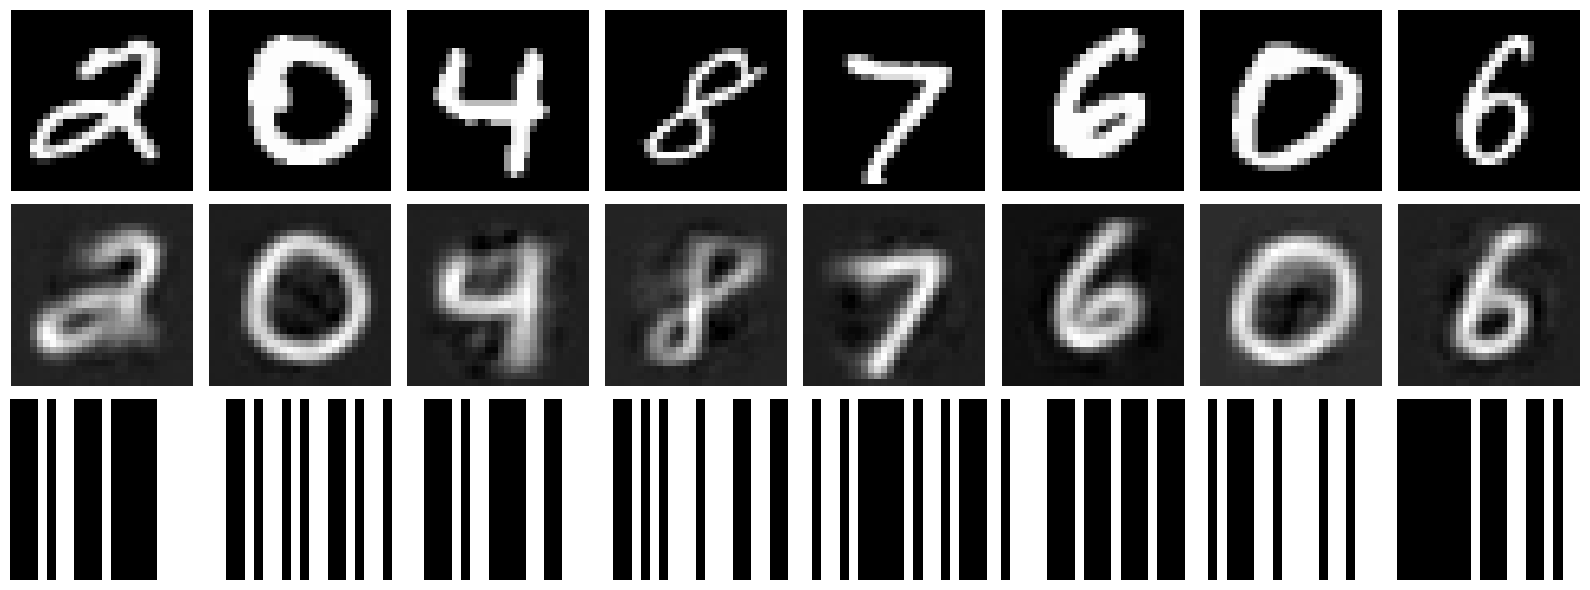

2025-04-04 10:59:31.216690: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [2]:
import jax
import jax.numpy as jnp
from jax import random, lax
from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from datasets.base import BaseDataset  # Assuming BaseDataset is available in your environment

# --- MNIST Dataset Loader ---
class MNISTDataset(BaseDataset):
    def __init__(self, split='train', num_examples=None, batch_size=32, image_size=(28, 28)):
        """
        Args:
            split (str): Which split to load ('train' or 'test').
            num_examples (int, optional): Number of examples to take.
            batch_size (int): Number of samples per batch.
            image_size (tuple): Resize images to this size.
        """
        self.split = split
        self.num_examples = num_examples
        self.batch_size = batch_size
        self.image_size = image_size

    def _preprocess(self, image, label):
        # Resize image and normalize to [0,1]
        image = tf.image.resize(image, self.image_size)
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    def load(self):
        ds = tfds.load('mnist', split=self.split, shuffle_files=True, as_supervised=True)
        if self.num_examples:
            ds = ds.take(self.num_examples)
        ds = ds.map(self._preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(self.batch_size)
        ds = ds.prefetch(tf.data.AUTOTUNE)
        return ds

# --- Binary Quantizer Function ---
def binary_quantizer(rng, logits):
    """Binary quantization using Bernoulli sampling."""
    probs = nn.sigmoid(logits)  # Convert logits to probabilities
    binary_sample = random.bernoulli(rng, probs).astype(jnp.float32)  # Sample 0 or 1
    # Straight-through estimator for gradients
    binary_latent = binary_sample + probs - lax.stop_gradient(probs)
    return binary_latent

# --- Model Definitions ---
class Encoder(nn.Module):
    """Binary VAE Encoder."""
    latents: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(500, name='fc1')(x)
        x = nn.relu(x)
        logits = nn.Dense(self.latents, name='fc2_logits')(x)
        return logits

class Decoder(nn.Module):
    """VAE Decoder."""
    @nn.compact
    def __call__(self, z):
        z = nn.Dense(500, name='fc1')(z)
        z = nn.relu(z)
        z = nn.Dense(784, name='fc2')(z)
        return z

class VAE(nn.Module):
    """Full Binary VAE model."""
    latents: int = 20

    def setup(self):
        self.encoder = Encoder(self.latents)
        self.decoder = Decoder()

    def __call__(self, x, z_rng):
        logits = self.encoder(x)
        z = binary_quantizer(z_rng, logits)
        recon_x = self.decoder(z)
        return recon_x, logits

    def generate(self, z):
        return nn.sigmoid(self.decoder(z))

def model(latents):
    return VAE(latents=latents)

# --- Trainer Code ---
class AutoencoderTrainState(train_state.TrainState):
    pass

class AutoencoderTrainer:
    def __init__(self, model, learning_rate, rng, input_shape):
        """
        Initializes the trainer.
        
        Args:
            model: The Flax autoencoder model.
            learning_rate: Learning rate for the optimizer.
            rng: A JAX random key.
            input_shape: Shape of the input data (e.g., (batch_size, features)).
        """
        self.rng = rng
        self.model = model
        self.learning_rate = learning_rate
        
        # Split RNG for initialization
        init_rng, self.rng = jax.random.split(rng)
        dummy_input = jnp.ones(input_shape, jnp.float32)
        # Our model expects an extra RNG for sampling
        params = self.model.init({'params': init_rng, 'dropout': init_rng}, dummy_input, self.rng)['params']
        optimizer = optax.adam(learning_rate)
        self.state = AutoencoderTrainState.create(
            apply_fn=self.model.apply, params=params, tx=optimizer)

    #@jax.jit
    def train_step(self, state, batch, rng):
        """
        A single training step that computes the loss, gradients, and updates parameters.
        """
        def loss_fn(params):
            recon_x, _ = self.model.apply({'params': params}, batch, rng)
            loss = jnp.mean((batch - recon_x) ** 2)
            return loss

        loss, grads = jax.value_and_grad(loss_fn)(state.params)
        state = state.apply_gradients(grads=grads)
        return state, loss

    def train_epoch(self, train_ds, batch_size):
        """
        Trains the model for one epoch.
        """
        # Convert tf.data.Dataset to numpy iterator for convenience
        train_iter = tfds.as_numpy(train_ds)
        epoch_loss = 0.0
        num_batches = 0

        for batch_data in train_iter:
            # Extract images (flatten them) from the batch; ignore labels
            images, _ = batch_data
            # Flatten images: [batch, H, W, C] -> [batch, H*W*C]
            images = images.reshape(images.shape[0], -1)
            self.rng, step_rng = jax.random.split(self.rng)
            self.state, loss = self.train_step(self.state, images, step_rng)
            epoch_loss += loss
            num_batches += 1

        return epoch_loss / num_batches if num_batches > 0 else float('nan')

    def train(self, train_ds, batch_size, num_epochs, eval_fn=None):
        """
        Runs the training loop for a given number of epochs.
        """
        for epoch in range(num_epochs):
            train_loss = self.train_epoch(train_ds, batch_size)
            print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}")
            if eval_fn is not None:
                eval_fn(self.state.params)

    def plot_reconstructions(self, test_ds, num_images=16):
        """
        Plots a grid of original images, reconstructions, and their latent codes.
        
        Args:
            test_ds: A tf.data.Dataset containing the test split.
            num_images: Number of images to display.
        """
        # Convert tf.data.Dataset to numpy iterator and take one batch
        test_iter = iter(tfds.as_numpy(test_ds))
        batch_data = next(test_iter)
        images, _ = batch_data
        # Flatten images
        images = images.reshape(images.shape[0], -1)
        # Use only the first num_images from the batch
        images = images[:num_images]
        # Get reconstruction and latent logits from the model
        self.rng, sample_rng = jax.random.split(self.rng)
        recon_images, logits = self.model.apply({'params': self.state.params}, images, sample_rng)
        # Compute latent code (binary quantization) from the logits
        z = binary_quantizer(sample_rng, logits)
        
        # Reshape images to (28, 28) and latent codes to (1, latents) for visualization
        images = images.reshape(-1, 28, 28)
        recon_images = recon_images.reshape(-1, 28, 28)
        # z has shape (num_images, latent_dim); we visualize each as a horizontal row
        z_vis = z  # shape: (num_images, latent_dim)
        
        # Plot original, reconstruction, and latent code in three rows
        n_cols = num_images
        fig, axs = plt.subplots(3, n_cols, figsize=(n_cols * 2, 6))
        for i in range(n_cols):
            axs[0, i].imshow(images[i], cmap='gray')
            axs[0, i].axis('off')
            if i == 0:
                axs[0, i].set_ylabel("Original", fontsize=8)
            axs[1, i].imshow(recon_images[i], cmap='gray')
            axs[1, i].axis('off')
            if i == 0:
                axs[1, i].set_ylabel("Reconstruction", fontsize=8)
            # For latent code, reshape it as a 1 x latent_dim image and plot as a heatmap
            axs[2, i].imshow(z_vis[i].reshape(1, -1), cmap='binary', aspect='auto')
            axs[2, i].axis('off')
            if i == 0:
                axs[2, i].set_ylabel("Latent Code", fontsize=8)
        plt.tight_layout()
        plt.show()


# --- Example Usage ---
if __name__ == '__main__':
    # Create a random key
    rng = random.PRNGKey(0)
    # Instantiate the binary VAE model with 20 latent dimensions
    binary_vae = model(latents=20)
    # Define input shape (e.g., batch of 64 images flattened to 784 features)
    input_shape = (64, 784)
    # Set learning rate
    learning_rate = 3e-4

    # Load MNIST dataset for training and testing
    train_dataset = MNISTDataset(split='train', batch_size=64, image_size=(28, 28)).load()
    test_dataset = MNISTDataset(split='test', batch_size=64, image_size=(28, 28)).load()

    # Create an instance of the trainer with your binary VAE model
    trainer = AutoencoderTrainer(binary_vae, learning_rate, rng, input_shape)

    # Train the model for 10 epochs
    trainer.train(train_dataset, batch_size=64, num_epochs=20)

    # Plot some reconstructions from the test dataset
    trainer.plot_reconstructions(test_dataset, num_images=8)